# A replication of the following EDA using newly released data

## "New data allows an initial look at ride hailing in Chicago"  
https://www.cmap.illinois.gov/updates/all/-/asset_publisher/UIMfSLnFfMB6/content/new-data-allows-an-initial-look-at-ride-hailing-in-chicago

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import geopandas as gpd
from shapely.geometry import Point, LineString, Polygon
import seaborn as sb
import bokeh, bokeh.plotting, bokeh.models
from bokeh.io import output_notebook, show
output_notebook()
import urllib
import dask.dataframe as dd
import dask.distributed

Loading BokehJS ...

In [2]:
tnc = pd.read_csv("TNC_trips_small.csv")

In [3]:
tnc.head(2)

,Unnamed: 0,Trip ID,Trip Start Timestamp,Trip End Timestamp,Trip Seconds,Trip Miles,Pickup Census Tract,Dropoff Census Tract,Pickup Community Area,Dropoff Community Area,...,Additional Charges,Trip Total,Shared Trip Authorized,Trips Pooled,Pickup Centroid Latitude,Pickup Centroid Longitude,Pickup Centroid Location,Dropoff Centroid Latitude,Dropoff Centroid Longitude,Dropoff Centroid Location
0,0,c7b547c1a9f083f80e3d1e86e01da3608c3f30ba,03/21/2019 03:45:00 PM,03/21/2019 05:00:00 PM,4621.0,21.8,1.703198e+10,1.703108e+10,76.0,8.0,...,7.55,35.05,False,1,41.979071,-87.903040,POINT (-87.9030396611 41.9790708201),41.890922,-87.618868,POINT (-87.6188683546 41.8909220259)
1,1,c7b549668b81eee3e0ffa418736929ffc16a7b39,03/06/2019 05:00:00 PM,03/06/2019 05:15:00 PM,1292.0,5.5,1.703106e+10,1.703108e+10,6.0,8.0,...,2.55,15.05,False,1,41.949061,-87.661643,POINT (-87.6616429039 41.9490605256),41.898332,-87.620763,POINT (-87.6207628651 41.8983317935)


In [4]:
#rename columns to change " " to "_" and lower capital letters
tnc.rename(columns=lambda x: x.strip().lower().replace(" ", "_"), inplace=True) 
# drop unnamed:_0 because it looks like a repetitive index column
tnc.drop('unnamed:_0', axis=1, inplace=True)

In [5]:
#read in Chicago census tract shapefile
census = gpd.read_file('census2010/census2010.shp')

In [6]:
tnc.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000000 entries, 0 to 999999
Data columns (total 21 columns):
trip_id                       1000000 non-null object
trip_start_timestamp          1000000 non-null object
trip_end_timestamp            1000000 non-null object
trip_seconds                  999964 non-null float64
trip_miles                    1000000 non-null float64
pickup_census_tract           716175 non-null float64
dropoff_census_tract          713243 non-null float64
pickup_community_area         942690 non-null float64
dropoff_community_area        935865 non-null float64
fare                          999999 non-null float64
tip                           999999 non-null float64
additional_charges            999999 non-null float64
trip_total                    999999 non-null float64
shared_trip_authorized        1000000 non-null bool
trips_pooled                  1000000 non-null int64
pickup_centroid_latitude      943464 non-null float64
pickup_centroid_longitude 

In [7]:
#slice tnc data
#keep only what we need
tnc_sliced = tnc[['trip_id','trip_start_timestamp','trip_end_timestamp',
                  'trip_miles','trip_seconds','pickup_census_tract', 
                  'dropoff_census_tract','fare', 'tip','additional_charges',
                  'trip_total','shared_trip_authorized','trips_pooled']]

In [8]:
tnc_sliced.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000000 entries, 0 to 999999
Data columns (total 13 columns):
trip_id                   1000000 non-null object
trip_start_timestamp      1000000 non-null object
trip_end_timestamp        1000000 non-null object
trip_miles                1000000 non-null float64
trip_seconds              999964 non-null float64
pickup_census_tract       716175 non-null float64
dropoff_census_tract      713243 non-null float64
fare                      999999 non-null float64
tip                       999999 non-null float64
additional_charges        999999 non-null float64
trip_total                999999 non-null float64
shared_trip_authorized    1000000 non-null bool
trips_pooled              1000000 non-null int64
dtypes: bool(1), float64(8), int64(1), object(3)
memory usage: 92.5+ MB


In [9]:
tnc_sliced.dropna(inplace = True)

//anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


#### Number of trips by Census Tract Heatmap

In [10]:
#change from float to integers
tnc_sliced.pickup_census_tract = tnc_sliced.pickup_census_tract.astype(int)
tnc_sliced.dropoff_census_tract = tnc_sliced.dropoff_census_tract.astype(int)
#change from integers to strings
tnc_sliced.pickup_census_tract = tnc_sliced.pickup_census_tract.astype(str)
tnc_sliced.dropoff_census_tract = tnc_sliced.dropoff_census_tract.astype(str)
tnc_sliced.info()

//anaconda3/lib/python3.7/site-packages/pandas/core/generic.py:5096: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[name] = value


<class 'pandas.core.frame.DataFrame'>
Int64Index: 681842 entries, 0 to 999999
Data columns (total 13 columns):
trip_id                   681842 non-null object
trip_start_timestamp      681842 non-null object
trip_end_timestamp        681842 non-null object
trip_miles                681842 non-null float64
trip_seconds              681842 non-null float64
pickup_census_tract       681842 non-null object
dropoff_census_tract      681842 non-null object
fare                      681842 non-null float64
tip                       681842 non-null float64
additional_charges        681842 non-null float64
trip_total                681842 non-null float64
shared_trip_authorized    681842 non-null bool
trips_pooled              681842 non-null int64
dtypes: bool(1), float64(6), int64(1), object(5)
memory usage: 68.3+ MB


In [11]:
counts = tnc_sliced.groupby('pickup_census_tract').count()

In [12]:
counts.head(2)

,trip_id,trip_start_timestamp,trip_end_timestamp,trip_miles,trip_seconds,dropoff_census_tract,fare,tip,additional_charges,trip_total,shared_trip_authorized,trips_pooled
pickup_census_tract,,,,,,,,,,,,
17031010100,372,372,372,372,372,372,372,372,372,372,372,372
17031010201,525,525,525,525,525,525,525,525,525,525,525,525


In [13]:
#merge pickup census tract with census tract shapefile
merged_p = counts.merge(census, left_on='pickup_census_tract', 
                        right_on = 'geoid10', how='left')
merged_p = gpd.GeoDataFrame(merged_p)

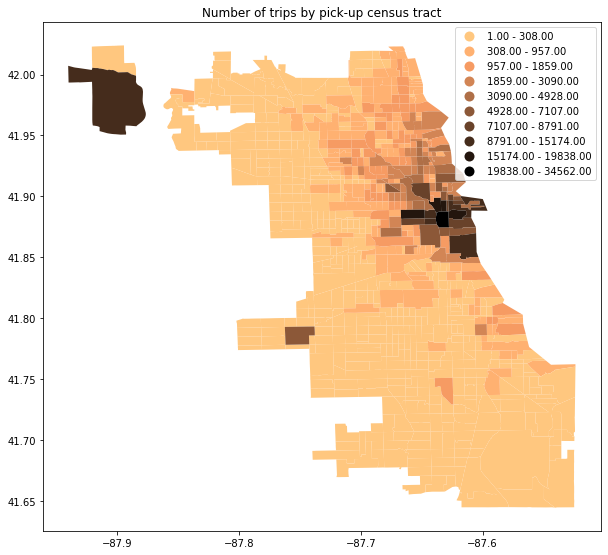

In [14]:
merged_p.plot(column="trip_id", cmap="copper_r", 
              scheme="fisher_jenks", k=10, alpha=1, figsize=(10,10),
              legend=True)
plt.title("Number of trips by pick-up census tract");

#### Number of trips citywide by time of day for each day of the week.

In [15]:
#the data we will be using to produce this graph is tnc_sliced 
#(which excludes all missing values)
tnc_sliced.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 681842 entries, 0 to 999999
Data columns (total 13 columns):
trip_id                   681842 non-null object
trip_start_timestamp      681842 non-null object
trip_end_timestamp        681842 non-null object
trip_miles                681842 non-null float64
trip_seconds              681842 non-null float64
pickup_census_tract       681842 non-null object
dropoff_census_tract      681842 non-null object
fare                      681842 non-null float64
tip                       681842 non-null float64
additional_charges        681842 non-null float64
trip_total                681842 non-null float64
shared_trip_authorized    681842 non-null bool
trips_pooled              681842 non-null int64
dtypes: bool(1), float64(6), int64(1), object(5)
memory usage: 68.3+ MB


In [16]:
tnc_sliced[['trip_id','trip_start_timestamp','trip_end_timestamp']].head(5)

,trip_id,trip_start_timestamp,trip_end_timestamp
0,c7b547c1a9f083f80e3d1e86e01da3608c3f30ba,03/21/2019 03:45:00 PM,03/21/2019 05:00:00 PM
1,c7b549668b81eee3e0ffa418736929ffc16a7b39,03/06/2019 05:00:00 PM,03/06/2019 05:15:00 PM
2,c7b54a83387eb3ddc8e396fd7762162aa2f4865e,11/25/2018 05:45:00 PM,11/25/2018 05:45:00 PM
3,c7b54afe4faed0b4246b1ba6f58b3db68a6fb320,11/09/2018 07:15:00 PM,11/09/2018 07:30:00 PM
4,c7b54b73c947d1c9942f60d4e7fa1cbfe04d5a32,01/06/2019 02:15:00 AM,01/06/2019 02:30:00 AM


In [17]:
tnc_sliced.trip_start_timestamp = tnc_sliced.trip_start_timestamp.astype('datetime64[ns]')  #takes very long

//anaconda3/lib/python3.7/site-packages/pandas/core/generic.py:5096: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[name] = value


In [18]:
tnc_sliced.trip_end_timestamp = tnc_sliced.trip_end_timestamp.astype('datetime64[ns]') 

In [19]:
#create a new column for week day (according to start time of the trip)
tnc_sliced['start_week_day'] = tnc_sliced.trip_start_timestamp.dt.dayofweek 

//anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [20]:
#create a new column for  start hour (according to start time of the trip)
tnc_sliced['start_hour'] = tnc_sliced.trip_start_timestamp.dt.hour

//anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [21]:
#replace day values with strings
d = {0:"Monday", 1:"Tuesday", 2:"Wednesday", 3:"Thursday",4:"Friday",5:"Saturday", 6:"Sunday"}
tnc_sliced.start_week_day.replace(to_replace=d, inplace=True)

//anaconda3/lib/python3.7/site-packages/pandas/core/generic.py:6586: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(new_data)


In [22]:
tnc_sliced.start_week_day.head(2) #check if changed properly

0     Thursday
1    Wednesday
Name: start_week_day, dtype: object

In [23]:
#change start week day to Categorical (ordinal) for plotting purpose
tnc_sliced['start_week_day']= pd.Categorical(tnc_sliced.start_week_day, ordered=True, 
                                             categories=['Monday', 'Tuesday', 'Wednesday','Thursday',
                                                         'Friday','Saturday','Sunday'])

//anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


In [24]:
grouped = tnc_sliced.groupby(['start_week_day', 'start_hour']).count()['trip_id']

In [25]:
grouped.head()

start_week_day  start_hour
Monday          0             1130
                1              505
                2              244
                3              126
                4              325
Name: trip_id, dtype: int64

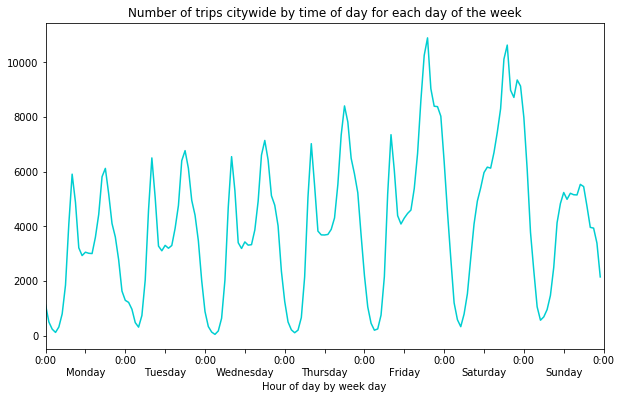

In [26]:
fig = grouped.plot(color='darkturquoise', figsize=(10,6))
plt.xticks(np.arange(0,169,12))
plt.xlabel("Hour of day by week day")
plt.title("Number of trips citywide by time of day for each day of the week")
labels = ["0:00",'\n'+'Monday',"0:00", '\n'+'Tuesday',"0:00", '\n'+'Wednesday',"0:00", '\n'+'Thursday', 
          "0:00",'\n'+'Friday', "0:00",'\n'+'Saturday',"0:00", '\n'+'Sunday', "0:00"]
fig.set_xticklabels(labels);

#### Citywide TNC usage peaks during congested commute periods 
(Miles per hour & trips per hour against time of day)

In [27]:
tnc_sliced.query('trip_seconds == 0')
#only 8, so we drop these

,trip_id,trip_start_timestamp,trip_end_timestamp,trip_miles,trip_seconds,pickup_census_tract,dropoff_census_tract,fare,tip,additional_charges,trip_total,shared_trip_authorized,trips_pooled,start_week_day,start_hour
6440,c7c1f8799489c0cc7d00f5b927222e150a026f88,2019-02-08 08:30:00,2019-02-08 08:30:00,1.2,0.0,17031280100,17031320100,5.0,0.0,0.72,5.72,True,1,Friday,8
131370,c8b2ea929b77750903a1e6ff1113eeeb344de641,2019-02-21 08:00:00,2019-02-21 08:00:00,1.0,0.0,17031320600,17031839100,5.0,0.0,0.72,5.72,True,2,Thursday,8
170294,c8fe0e96d265454c73bcb084ea426e309ddbe0f7,2019-01-23 08:30:00,2019-01-23 08:30:00,0.0,0.0,17031081100,17031081100,0.0,0.0,0.67,0.67,True,4,Wednesday,8
432560,caf7df296e7f0d44f625df12af9d468af6800b81,2019-01-22 21:45:00,2019-01-22 21:45:00,0.3,0.0,17031040402,17031830800,2.5,0.0,0.67,3.17,True,1,Tuesday,21
472138,cb443b43304a9f85bdcaa74568b51c52c42c91bd,2019-03-26 08:30:00,2019-03-26 08:30:00,1.6,0.0,17031081800,17031839100,5.0,0.0,0.72,5.72,False,1,Tuesday,8
693866,ccf0be84981ab9a4056f8437a5857b083a5a8778,2019-03-03 16:15:00,2019-03-03 16:15:00,0.4,0.0,17031833000,17031280100,2.5,0.0,0.72,3.22,True,1,Sunday,16
752177,cd60c84a475059fa8d6240a0104149763f919dc7,2019-01-23 17:15:00,2019-01-23 17:15:00,0.0,0.0,17031280100,17031280100,0.0,0.0,0.67,0.67,True,1,Wednesday,17
809847,cdd0363c5b18d4964dd17886bb67b4b1633a4198,2019-02-07 09:30:00,2019-02-07 09:30:00,0.0,0.0,17031842200,17031842200,2.5,4.0,2.55,9.05,False,1,Thursday,9


In [28]:
#drop the trips with trip_seconds == 0
indices = tnc_sliced.query('trip_seconds == 0').index
tnc_sliced.drop(indices, inplace=True)

//anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:3940: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


In [29]:
#calculate miles per hour
tnc_sliced['speed'] = tnc_sliced['trip_miles']/tnc_sliced['trip_seconds']*60*60

//anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [30]:
#average speed by hour of day
grouped_speed = tnc_sliced.groupby(['start_hour']).mean()['speed']

In [31]:
#total trips per hour
grouped_trip = tnc_sliced.groupby(['start_hour']).count()['trip_id']

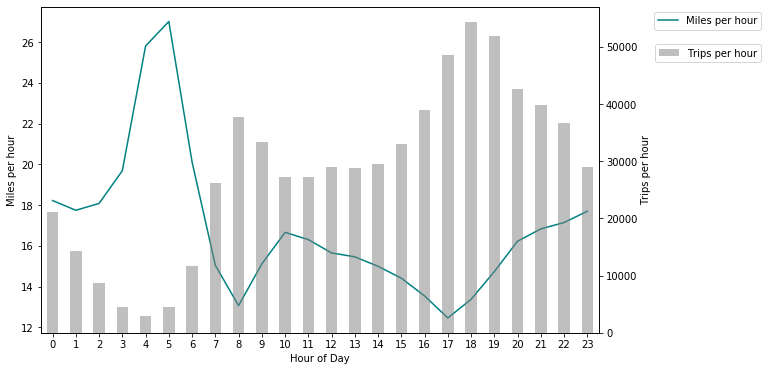

In [32]:
fig, ax = plt.subplots(figsize=(10,6))
ax.plot(grouped_speed, color='teal')
ax.set_xlabel('Hour of Day')
ax.set_ylabel('Miles per hour')
ax.legend(['Miles per hour'], bbox_to_anchor=(1.3, 1.0))
ax_twin = ax.twinx() 
grouped_trip.plot.bar(color='gray', alpha=0.5)
ax_twin.set_ylabel('Trips per hour')
ax_twin.legend(['Trips per hour'], bbox_to_anchor=(1.3, 0.9));

#### Percent of trips shared and trips per hour by EDA (economically disconnected areas)

In [33]:
#read in economically disconnected areas data
edas = pd.read_csv('edas.csv')
edas = edas[['side','GEOID10']]
edas.GEOID10 = edas.GEOID10.astype(str)
#merge tnc data with data on economically disconnected areas (by census tract ID)
tnc_edas = tnc_sliced.merge(edas, left_on='pickup_census_tract', right_on = 'GEOID10', how='left')

In [34]:
#fill missing values with "non-EDA"
tnc_edas.side = tnc_edas.side.fillna('non-EDA')

In [35]:
noneda = tnc_edas.query('side=="non-EDA"')
north = tnc_edas.query('side=="North/Northwest"')
south = tnc_edas.query('side=="South/Southwest"')
west = tnc_edas.query('side=="West"')

In [77]:
#calculate each area's percent of shared rides authorized
grouped_north = north.groupby('start_hour')['shared_trip_authorized'].apply(lambda x: sum(x)/len(x))
grouped_noneda = noneda.groupby('start_hour')['shared_trip_authorized'].apply(lambda x: sum(x)/len(x))
grouped_south = south.groupby('start_hour')['shared_trip_authorized'].apply(lambda x: sum(x)/len(x))
grouped_west = west.groupby('start_hour')['shared_trip_authorized'].apply(lambda x: sum(x)/len(x))

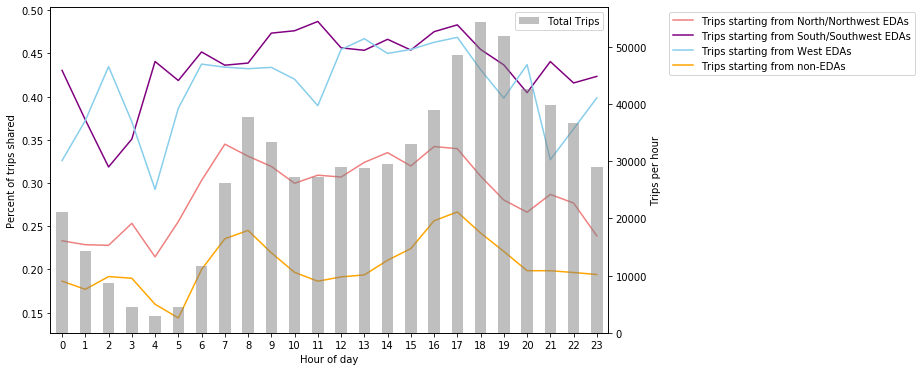

In [78]:
fig, ax= plt.subplots(figsize=(10,6))
ax.plot(grouped_north, color='lightcoral')
ax.set_xlabel('Hour of day')
ax.set_ylabel('Percent of trips shared')
ax.plot(grouped_south, color='purple')
ax.plot(grouped_west, color='skyblue')
ax.plot(grouped_noneda, color='orange')
ax.legend(['Trips starting from North/Northwest EDAs',
           'Trips starting from South/Southwest EDAs',
           'Trips starting from West EDAs',
           'Trips starting from non-EDAs'], bbox_to_anchor=(1.1,1))
ax_twin = ax.twinx() 
grouped_trip.plot.bar(color='gray', alpha=0.5)
ax_twin.set_ylabel('Trips per hour')
ax_twin.legend(['Total Trips']);